# Attempt to Model Velocity Dependence
Attempt to model the change in stopping force as a function of velocity

In [36]:
%matplotlib inline
import sys
import os

# Add the directory containing your module to the Python path
sys.path.append(os.path.abspath('/scratch/users/pdanie20/silicon/PD-stopping-power-ml'))
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in Data
Read in data from all velocities, and a new featurizer

In [37]:
data = pd.read_pickle(os.path.join('..', 'training_data.pkl.gz'))

In [38]:
with open('featurizer.pkl', 'rb') as fp:
    featurizer = pkl.load(fp)

In [39]:
start_frame = pkl.load(open(os.path.join('..', 'Si_starting_frame.pkl'), 'rb'))

## Separate Channel and Random Trajectories
Let's train first on the random trajectories as a starting point

In [40]:
patterns = [
    r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction/v_0.5',
    r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction/v_1.5',
    r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction/v_2.0',
    r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction/v_3.0',
    r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction/v_4.0'
]

# Combine the patterns into a single regex pattern
combined_pattern = '|'.join(patterns)

#pattern = r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction'
channel_data = data[data['directory'].str.contains(combined_pattern, regex=True)]
print('Selected {} training entries'.format(len(channel_data)))
#print(channel_data.head)
# import pickle

# # Load the pickle file
# with open('channel_traj.pkl', 'rb') as file:
#     da = pickle.load(file)
# keys = da.keys()
# print("Keys in the pickle file:")
# for key in keys:
#         print(key)
# print(da.head)

Selected 8599 training entries


Get the random trajecotries

In [41]:
data = data[data['directory'].str.contains('silicon_data/2_Electronic_Stopping/H_Si/LDA_H_off_channel')]
print('Selected {} training entries'.format(len(random_data)))


Selected 5053 training entries


## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

Text(0, 0.5, 'Force')

/usr/local/python/3.9.16/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  func(*args, **kwargs)


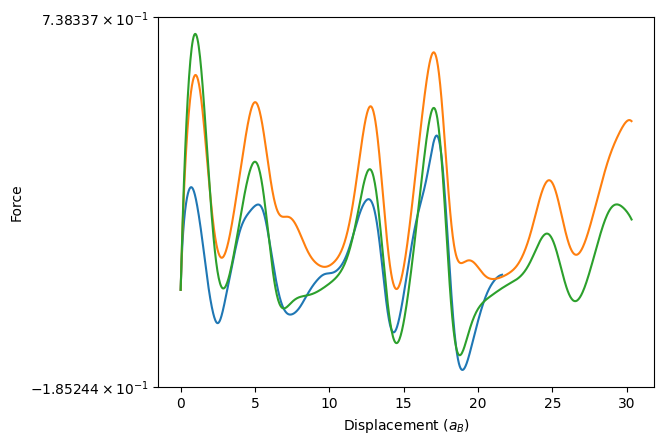

In [42]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid)

#ax.legend(ncol=2)
ax.set_yscale('symlog')
    
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

#ax.set_ylim(-100,100)

Text(0, 0.5, 'Force')

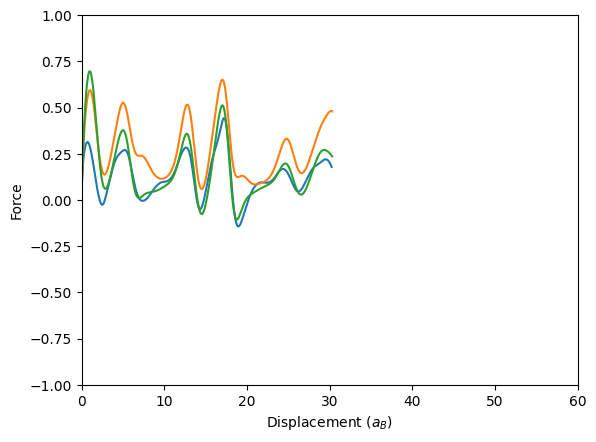

In [43]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.set_xlim(0, 60)

ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

Andre uses 6 $a_B$

In [44]:
data.query('displacement >= 6', inplace=True)

## Generate Features
Use the same features at the Al model

In [45]:
X_cols = featurizer.feature_labels()
y_col = 'force'

## Mark the Average Range on the Channel Dataset
Let's average the 2nd and third repeats

In [46]:
lat_spacing = start_frame.cell[0,0] / 4

In [47]:
channel_data['average_range'] = np.logical_and(channel_data['displacement'] > lat_spacing, channel_data['displacement'] <= lat_spacing * 3)
#np.logical_and?

## Fit on Entire Dataset
Use the Bayesian Ridge Regression model from previous examples. 

In [48]:
model = pkl.load(open(os.path.join('..', 'single-velocity', 'best_model.pkl'), 'rb'))

In [49]:
model.param_grid = {'lasso_rfe__estimator__max_iter': range(40, 80, 2)}

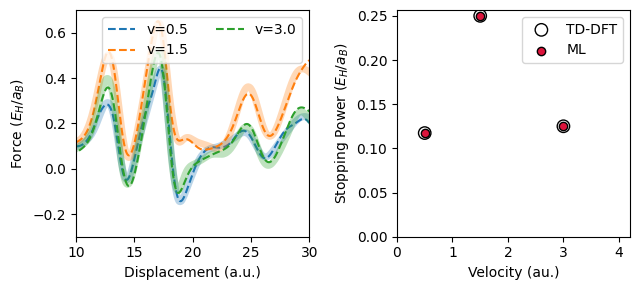

In [50]:
model.fit(data[X_cols], data[y_col])
data['force_fit'] = model.predict(data[X_cols])

fig, ax = plt.subplots(1, 2)

velocity = []
stopping_pred = []
stopping_actual = []
for gid, group in data.groupby('directory'):
    velocity.append(float(gid[-3:]))

    # Plot the performance
    my_line, = ax[0].plot(group['displacement'], group['force'], linestyle='--', label='v='+gid[-3:])

    ax[0].plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)

    #ax[0].set_xlim(30, 40)
    ax[0].set_xlim(10, 30)
    #ax[0].set_ylim(-0.3, 0.7)
    ax[0].set_ylim(-0.3, 0.7)
    ax[0].legend(ncol=2)

    ax[0].set_xlabel('Displacement (a.u.)')
    ax[0].set_ylabel('Force ($E_H / a_B$)')

    # Plot the mean velocity
    stopping_pred.append(group['force_fit'].mean())
    stopping_actual.append(group['force'].mean())

# Plot the stopping power
ax[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
ax[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')

ax[1].set_ylabel('Stopping Power ($E_H / a_B$)')
ax[1].set_xlabel('Velocity (au.)')
ax[1].set_ylim(0, max(ax[1].get_ylim()))
ax[1].set_xlim(0, 4.2)
ax[1].legend()

fig.set_size_inches(6.5, 3)
fig.tight_layout()

In [51]:
stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
print(f'Mean percent error: {stopping_mape * 100:.2f}%')

Mean percent error: 0.00%


The model fails to capture the trends in stopping power with velocity. We might just need more complexity

## Save Data
Save the training set used by this model

In [52]:
random_data.to_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))

In [53]:
channel_data.to_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'channel_traj.pkl'))

In [54]:
import pickle

# Load the pickle file
with open('channel_traj.pkl', 'rb') as file:
    data = pickle.load(file)
keys = data.keys()
print("Keys in the pickle file:")
for key in keys:
        print(key)
print(data.head)

Keys in the pickle file:
frame_id
force
position
velocity
energy
file_id
file
timestep
displacement
directory
charge density at t=-4.00
charge density at t=-3.00
charge density at t=-2.00
charge density at t=-1.00
charge density at t=-0.50
charge density at t=0.00
charge density at t=0.50
charge density at t=1.00
charge density at t=2.00
AGNI projected eta=8.00e-01
AGNI projected eta=1.23e+00
AGNI projected eta=1.88e+00
AGNI projected eta=2.89e+00
AGNI projected eta=4.43e+00
AGNI projected eta=6.80e+00
AGNI projected eta=1.04e+01
AGNI projected eta=1.60e+01
ion-ion repulsion
velocity_mag
average_range
<bound method NDFrame.head of        frame_id         force                               position  \
8424          0 -4.700000e-07        [2.539087, 5.078175, -10.15635]   
8425          1  6.818769e-02     [2.53908699, 5.078175, -10.098474]   
8426          2  1.325307e-01   [2.53908698, 5.078175, -10.04059801]   
8427          3  1.908756e-01    [2.53908695, 5.078175, -9.98272203]   
8